# คำนวณค่าการบดบังลำบีม CBB เพื่อนำไปใช้เป็นปัจจัยในการถ่วงค่าน้ำหนักร่วมกับ pulse volume
* จำนวน 4 สถานี คือ เชียงราย ลำพูน พิษณุโลก ชัยนาท
* พิกัดของ CBB จะเป็น geographic coordinates หรือ lat-lon แต่ coord ในโปรแกรมโมเสค กำหนดเป็น UTM ดังนั้นต้องนำ CBB ไป reproject แล้วต้อง interpolate ให้มี shape, dimension ตรงกันกับ coord

In [1]:
import wradlib as wrl
import numpy as np
import os
import matplotlib.pyplot as plt

def read_dem(filename, spacing=0.0005):
    ds = wrl.io.open_raster(filename)
    ds = wrl.georef.reproject_raster_dataset(ds, spacing=spacing)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=32767)
    return rastercoords, rastervalues

def calculate_cbb(sitecoords, nrays, nbins, bw, range_res, el, rastercoords, rastervalues):
    r = np.arange(nbins) * range_res
    beamradius = wrl.util.half_power_radius(r, bw)

    coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
    coords = wrl.georef.spherical_to_proj(coord[..., 0], coord[..., 1], coord[..., 2], sitecoords)
    lon = coords[..., 0]
    lat = coords[..., 1]
    alt = coords[..., 2]
    polcoords = np.dstack((lon, lat))
    
    polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues, polcoords, order=3, prefilter=False)

    PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
    PBB = np.ma.masked_invalid(PBB)

    CBB = wrl.qual.cum_beam_block_frac(PBB)
    
    return CBB, lon, lat

# Radar parameters
radars = {
    "CHN": {"sitecoords": (100.191239,15.157808,17.0), "dem_file": "../1data/2DEM/wrl_dem_chn1.tif", "el": 0.5},
    "CRI": {"sitecoords": (99.881618,19.961643, 387.0), "dem_file": "../1data/2DEM/wrl_dem_cri1.tif", "el": 1.0},
    "LMP": {"sitecoords": (99.039000,18.566567,301.0), "dem_file": "../1data/2DEM/wrl_dem_lmp1.tif", "el": 1.0},
    "PHS": {"sitecoords": (100.217977,16.775380,45.0), "dem_file": "../1data/2DEM/wrl_dem_phk1.tif", "el": 0.5},
}

nrays = 360
nbins = 480
bw = 1.0
range_res = 500.0

output_dir = "cbb_outputs"
os.makedirs(output_dir, exist_ok=True)

C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\ipol.py:1712: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  interp = ndimage.interpolation.map_coordinates(values, [yi, xi], **kwargs)
C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\qual.py:123: RuntimeWarning: divide by zero encountered in divide
  ya = y / a
C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\qual.py:127: RuntimeWarning: invalid value encountered in sqrt
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\qual.py:127: RuntimeWarning: invalid value encountered in arcsin
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21844\2933419092.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, 

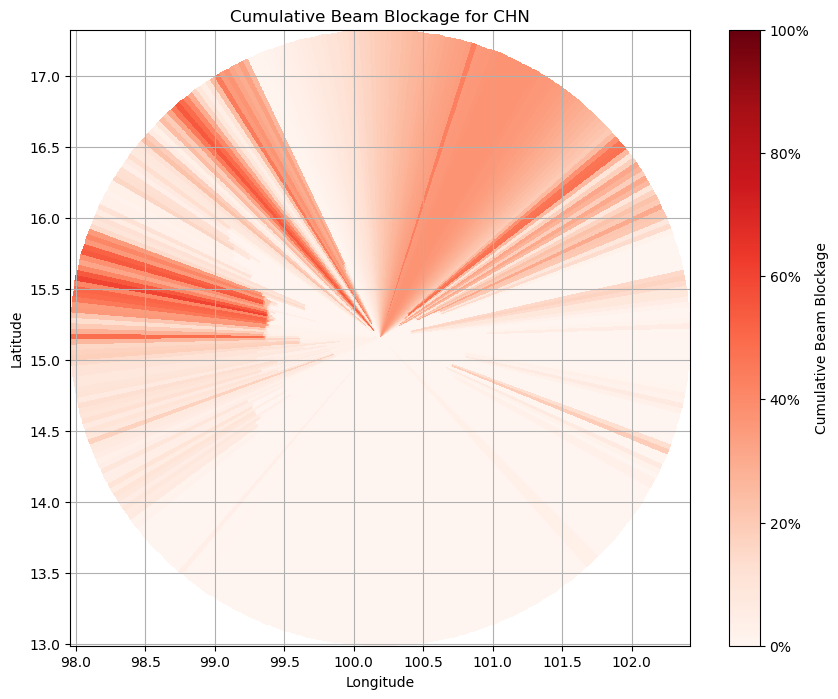

Saved CBB for CHN to cbb_outputs\CHN_CBB.npy


C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\ipol.py:1712: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  interp = ndimage.interpolation.map_coordinates(values, [yi, xi], **kwargs)


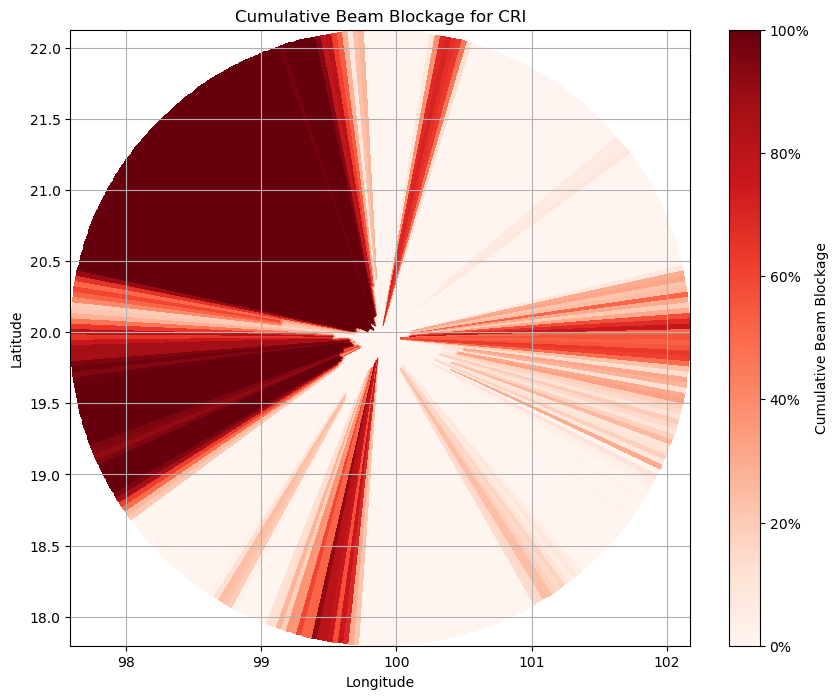

Saved CBB for CRI to cbb_outputs\CRI_CBB.npy


C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\ipol.py:1712: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  interp = ndimage.interpolation.map_coordinates(values, [yi, xi], **kwargs)


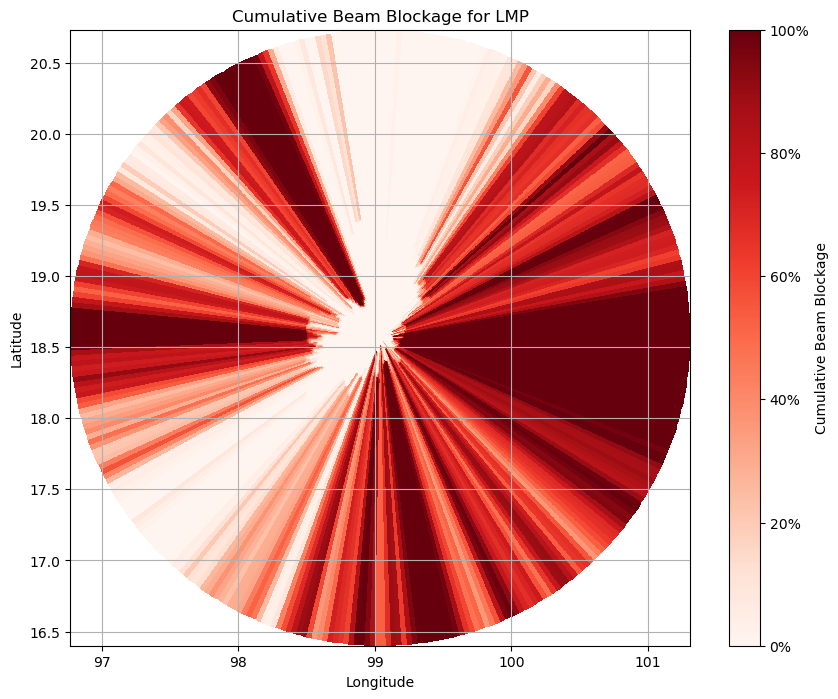

Saved CBB for LMP to cbb_outputs\LMP_CBB.npy


C:\Users\Admin\anaconda3\envs\mossf\lib\site-packages\wradlib\ipol.py:1712: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  interp = ndimage.interpolation.map_coordinates(values, [yi, xi], **kwargs)


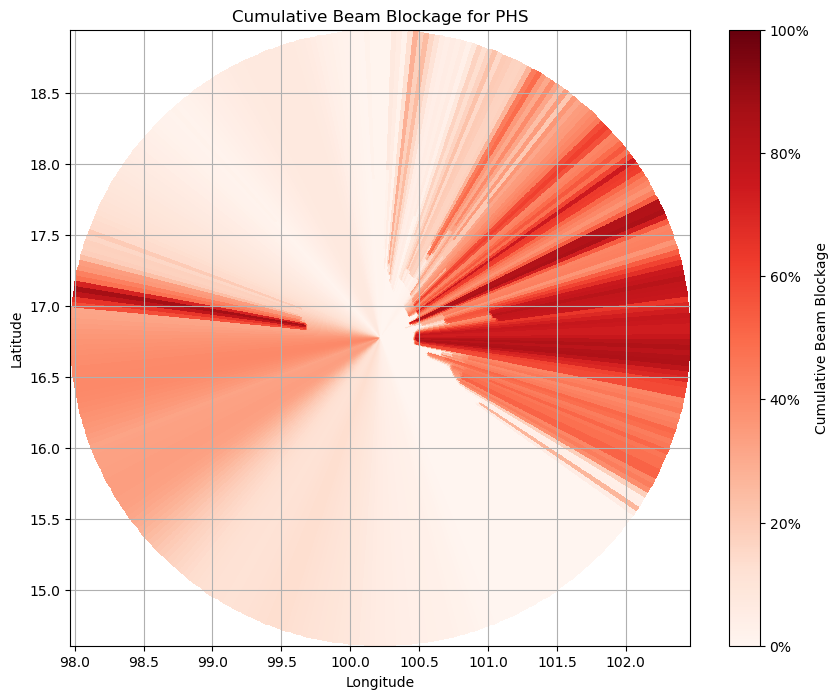

Saved CBB for PHS to cbb_outputs\PHS_CBB.npy


In [2]:
for radar, params in radars.items():
    sitecoords = params["sitecoords"]
    dem_file = params["dem_file"]
    el = params["el"]
    
    # Read DEM data
    rastercoords, rastervalues = read_dem(dem_file)
    
    # Calculate CBB
    CBB, lon, lat = calculate_cbb(sitecoords, nrays, nbins, bw, range_res, el, rastercoords, rastervalues)
    
    # Plotting the CBB
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(lon, lat, CBB, cmap='Reds', shading='auto',vmin=0, vmax=1)
    cbar = plt.colorbar()
    cbar.set_label('Cumulative Beam Blockage')
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    
    plt.title(f'Cumulative Beam Blockage for {radar}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
    
    # Save CBB to file
    output_path = os.path.join(output_dir, f"{radar}_CBB.npy")
    np.save(output_path, CBB)
    print(f"Saved CBB for {radar} to {output_path}")